In [80]:
import torch
import torch.nn as nn
from torch import optim
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

In [81]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {DEVICE}")

Using Device: cpu


In [82]:
import numpy as np
from torchvision import datasets

# Load CIFAR10 raw (train only) to compute mean image
cifar_train = datasets.CIFAR10(root="./data", train=True, download=True)
X = np.stack([np.array(img) for img, _ in cifar_train])  # (50000, 32, 32, 3)
mean_image = X.mean(axis=0)  # (32, 32, 3)


100.0%


In [83]:
from torchvision import transforms

CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD  = [0.2470, 0.2435, 0.2616]


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    transforms.Lambda(torch.flatten)
])


In [84]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# Load full training set (50k samples)
full_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

# Create 45k / 5k split
train_size = 45000
val_size   = 5000

train_ds, val_ds = random_split(full_train, [train_size, val_size])

# Load test set separately
test_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=200, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=200, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=200, shuffle=False)


In [85]:
img, label = train_ds[32]
print(img.shape)

torch.Size([3072])


In [86]:
class SoftmaxClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3072, 10)

    def forward(self, x):
        x = self.linear(x)
        return x

In [87]:
model = SoftmaxClassifier()
model

SoftmaxClassifier(
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

In [88]:

def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)

            logits = model(X)
            loss = criterion(logits, y)

            running_loss += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc


def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, y in train_loader:
        X = X.to(device)   # X: (batch, 3072)
        y = y.to(device)

        # Forward
        logits = model(X)
        loss = loss_fn(logits, y)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item() * y.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

In [89]:
learning_rate = 1e-2
reg = 1e-3
num_epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)


In [90]:
def train_model(
    lr,
    weight_decay,
    num_epochs,
    train_loader,
    val_loader,
    device=DEVICE,
):
    model = SoftmaxClassifier().to(device)

    optimizer = optim.SGD(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay,
    )

    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        print(
            f"[lr={lr:.1e}, wd={weight_decay:.1e}] "
            f"Epoch {epoch:02d} | "
            f"train loss {train_loss:.4f}, acc {train_acc:.3f} | "
            f"val loss {val_loss:.4f}, acc {val_acc:.3f}"
        )

    return best_val_acc, best_state


In [91]:
best_val_acc, best_state = train_model(
    lr=learning_rate,
    weight_decay=reg,
    num_epochs=num_epochs,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    )

[lr=1.0e-02, wd=1.0e-03] Epoch 01 | train loss 1.8763, acc 0.352 | val loss 1.8141, acc 0.371
[lr=1.0e-02, wd=1.0e-03] Epoch 02 | train loss 1.7853, acc 0.387 | val loss 1.7724, acc 0.399


KeyboardInterrupt: 

In [ ]:
best_model = SoftmaxClassifier().to(DEVICE)
best_model.load_state_dict(best_state)

test_loss, test_acc = evaluate(best_model, test_loader, loss_fn, DEVICE)
print(f"\nTest loss: {test_loss:.4f}, test acc: {test_acc:.3f}")


Test loss: 1.7773, test acc: 0.390


### Hyper parameter tuning

In [ ]:
import math

learning_rates = [1e-3, 3e-3, 1e-2]
weight_decays  = [0.0, 1e-4, 5e-4, 1e-3]

num_epochs = 10  # keep small for tuning; bump later for the best combo

results = {}
best_overall_acc = 0.0
best_overall_cfg = None
best_overall_state = None

for lr in learning_rates:
    for wd in weight_decays:
        print("=" * 60)
        print(f"Training with lr={lr:.1e}, weight_decay={wd:.1e}")
        best_val_acc, best_state = train_model(
            lr=lr,
            weight_decay=wd,
            num_epochs=num_epochs,
            train_loader=train_loader,
            val_loader=val_loader,
            device=DEVICE,
        )
        results[(lr, wd)] = best_val_acc
        print(f"Best val acc for lr={lr:.1e}, wd={wd:.1e}: {best_val_acc:.3f}")

        if best_val_acc > best_overall_acc:
            best_overall_acc = best_val_acc
            best_overall_cfg = (lr, wd)
            best_overall_state = best_state

print("\nHyperparameter search results:")
for (lr, wd), acc in sorted(results.items(), key=lambda x: -x[1]):
    print(f"lr={lr:.1e}, wd={wd:.1e} -> best val acc = {acc:.3f}")

print("\nBest overall config:")
print(f"lr={best_overall_cfg[0]:.1e}, wd={best_overall_cfg[1]:.1e}, val acc={best_overall_acc:.3f}")


Training with lr=1.0e-03, weight_decay=0.0e+00
[lr=1.0e-03, wd=0.0e+00] Epoch 01 | train loss 2.0388, acc 0.275 | val loss 1.9266, acc 0.332
[lr=1.0e-03, wd=0.0e+00] Epoch 02 | train loss 1.8960, acc 0.346 | val loss 1.8716, acc 0.359
[lr=1.0e-03, wd=0.0e+00] Epoch 03 | train loss 1.8553, acc 0.364 | val loss 1.8447, acc 0.369
[lr=1.0e-03, wd=0.0e+00] Epoch 04 | train loss 1.8315, acc 0.374 | val loss 1.8278, acc 0.374
[lr=1.0e-03, wd=0.0e+00] Epoch 05 | train loss 1.8152, acc 0.381 | val loss 1.8159, acc 0.379
Best val acc for lr=1.0e-03, wd=0.0e+00: 0.379
Training with lr=1.0e-03, weight_decay=1.0e-04
[lr=1.0e-03, wd=1.0e-04] Epoch 01 | train loss 2.0423, acc 0.271 | val loss 1.9266, acc 0.334
[lr=1.0e-03, wd=1.0e-04] Epoch 02 | train loss 1.8989, acc 0.343 | val loss 1.8688, acc 0.357
[lr=1.0e-03, wd=1.0e-04] Epoch 03 | train loss 1.8571, acc 0.362 | val loss 1.8412, acc 0.369
[lr=1.0e-03, wd=1.0e-04] Epoch 04 | train loss 1.8325, acc 0.373 | val loss 1.8247, acc 0.380
[lr=1.0e-03, 

In [93]:
best_val_acc, best_state = train_model(
    lr=1.0e-02,
    weight_decay=1.0e-03,
    num_epochs=10,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    )

best_model = SoftmaxClassifier().to(DEVICE)
best_model.load_state_dict(best_state)

test_loss, test_acc = evaluate(best_model, test_loader, loss_fn, DEVICE)
print(f"\nTest loss: {test_loss:.4f}, test acc: {test_acc:.3f}")

[lr=1.0e-02, wd=1.0e-03] Epoch 01 | train loss 1.8808, acc 0.347 | val loss 1.8032, acc 0.378
[lr=1.0e-02, wd=1.0e-03] Epoch 02 | train loss 1.7855, acc 0.385 | val loss 1.7695, acc 0.397
[lr=1.0e-02, wd=1.0e-03] Epoch 03 | train loss 1.7541, acc 0.402 | val loss 1.7643, acc 0.397
[lr=1.0e-02, wd=1.0e-03] Epoch 04 | train loss 1.7377, acc 0.407 | val loss 1.7474, acc 0.404
[lr=1.0e-02, wd=1.0e-03] Epoch 05 | train loss 1.7232, acc 0.410 | val loss 1.7447, acc 0.407
[lr=1.0e-02, wd=1.0e-03] Epoch 06 | train loss 1.7123, acc 0.417 | val loss 1.7496, acc 0.395
[lr=1.0e-02, wd=1.0e-03] Epoch 07 | train loss 1.7052, acc 0.419 | val loss 1.7482, acc 0.399
[lr=1.0e-02, wd=1.0e-03] Epoch 08 | train loss 1.6964, acc 0.422 | val loss 1.7492, acc 0.402
[lr=1.0e-02, wd=1.0e-03] Epoch 09 | train loss 1.6898, acc 0.425 | val loss 1.7420, acc 0.403
[lr=1.0e-02, wd=1.0e-03] Epoch 10 | train loss 1.6843, acc 0.425 | val loss 1.7378, acc 0.409

Test loss: 1.7376, test acc: 0.401


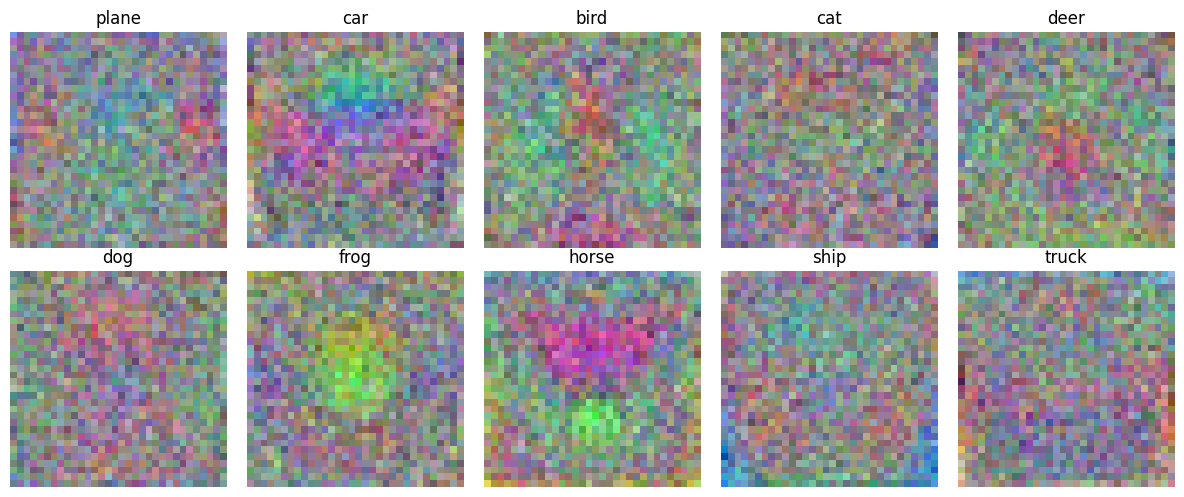

In [94]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.

# Extract weights from the model
# PyTorch Linear layer stores weights as (out_features, in_features) = (10, 3072)
# We transpose to get (3072, 10) to match the NumPy version format
w = best_model.linear.weight.data.cpu().numpy().T  # (3072, 10)

# Reshape to (3, 32, 32, 10) - channels first format (matching PyTorch input format)
# Then transpose to (32, 32, 3, 10) for visualization (matching NumPy version)
w = w.reshape(3, 32, 32, 10).transpose(1, 2, 0, 3)  # (32, 32, 3, 10)

# Normalize for visualization
w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

plt.tight_layout()
plt.show()
